# User Profile using Cluster Analysis of Personal IMDB Ratings
### Objectives:
Data downloaded from user account with ratings given to ~350 movies, performing general analysis and clustering on the IMDb data to :
1. Create a <b>User profile</b> to find patterns in <b>My IMDb movie Ratings </b>over a period of 5 Years.<b> Find insights about preferences etc., Important Features </b>
2. Find Interesting Clusters of Movies Using <b>K-Means, K-modes</b> Clustering for categorical data, <b>K-Protoype </b> Clustering for mixed type data.
3. Used one-hot encoded categorical data and PCA to perform K-means clustering to see if output improves, not good practise as one-hot encoded categorical data in Euclidean space is not a good fit with K-means and PCA. The output using categorical data and Hamming distance used by K-modes, K-prototypes gave better output.
4. <b>Selection of number of clusters and analysis of cluster quality</b> using SSE(sum of the squared differences between each observation and its cluster's mean) and elbow method, silhoutte analysis. Also used Regression models to quantify cluster quality as a function of performance of models at predicting rating.(although this is target leakage, can measure how encoding of preference).
5. <b> Visualised clusters </b>using T-SNE and PCA. 
4. Statistically significance of clusters investigated by performing <b>hypothesis tests </b> with respect to mean Ratings of entire dataset.
7. Interpreted clusters and attempted to create a user profile.

Data Source : IMDb Account and extra data from OMDB API, wrangling steps in accompanying wrangling notebook.

### Insights :
<p> <b>Statisticaly Significant Clusters </b>indicate:<br>
    1. Preferences - Older critically acclaimed movies, Dramas, biographies, etc.<br>
    2. Dislikes - Newer Hindi movies, Newer comedies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings

pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [2]:
path = str(Path.cwd()) + '/Data/enriched_film_data_april.csv'

data_film = pd.read_csv(path, engine='python', index_col=0)

# Keeping Backup Dataframe
data_film_orig = data_film.copy()
data_film_backup = data_film.copy()
# Adding back a numerical column and imputing missing values - Used regression model to find relationship
# between ratings and Metascore
data_extra = pd.read_csv('Data/Film_data_from_OMDB_API.csv', index_col=0)
data_film['Metascore'] = data_extra.Metascore
data_film.Metascore.loc[data_film.Metascore.isna()] =(data_film['IMDb Rating'].loc[data_film.Metascore.isna()] * 9.87012987012987).astype(int)

## 1. Exploratory Analysis & Visualizations

### Univariate 

#### BoxPlots for Quantitative Vars.
Insights:
1. Most of the Ratings lie between the rating 7 and 8, this is slightly lower compared to the IMDb users, But this could be misleading as Discrete vs Continuous Comaprison.
2. Run time of movies seem to have less of an impact of ratings.
3. Although most movies watched are newer, their is a long tail towards older movies.
4. Majority of the movies watched are on the lower end of Popularity. 
5. Please ignore Major_awards since it is a binary categorical column. Interesting to note is that the number of films with some form of major awards recognition is higher than those without it.

In [3]:
def plot_box_num_uni(df):
    """ Plots Boxplots for all Numerical Columns in Dataframe.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 3, i+1)
        sns.boxplot(x = str(item), data = df)
        ax.set_title(item)

    fig.show()

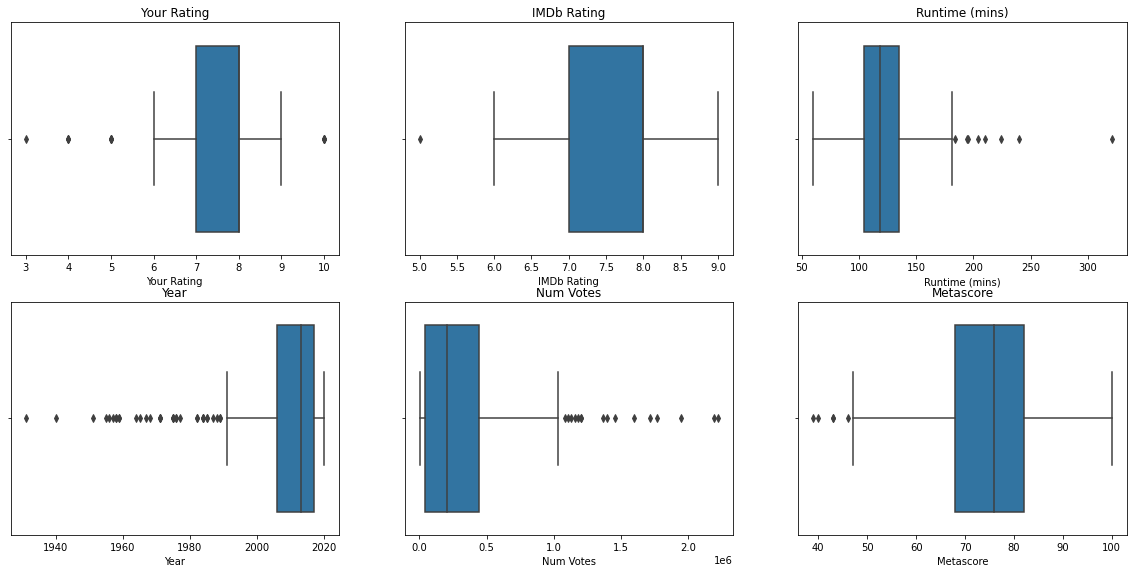

In [4]:
# only using numerical columns and removing binary column
num_columns = data_film.select_dtypes([np.number]).columns.to_list()
num_columns.remove('Major_Awards')
# converting IMDb ratings to discrete to match Discrete Your ratings, loss of info. but useful for comparison.
data_film['IMDb Rating'] = np.round(data_film['IMDb Rating'])
plot_box_num_uni(data_film[num_columns])

#### Division of Ratings accross Genres
Splitting compound Director/Genre and only keeping primary Genre/Director.<br>
Again most common rating appears to be an 8 with only Action movies/Documentaries having a different mode.

In [5]:
data_film[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7']] = data_film.Genres.str.split(',', expand=True)
data_film.drop(['Genre2','Genre3', 'Genre4','Genre5','Genre6','Genre7'], axis= 1, inplace = True)
# Loss of info by dropping secondary, tertiary genres but will result in duplication, is complex.

In [6]:
# Loss of info, Lee ukreich, ethan and joel coen etc are big loosers. Complex fix later.
data_film[['Director1','Director2','Director3', 'Director4']] = data_film.Directors.str.split(',', expand=True)
data_film.drop(['Director2','Director3', 'Director4'], axis = 1, inplace = True)

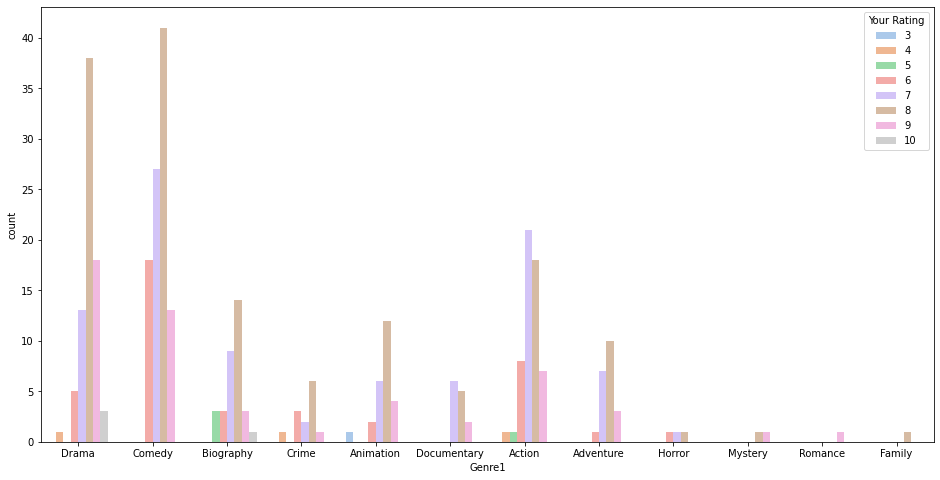

In [7]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x = 'Genre1', data = data_film, hue="Your Rating", palette="pastel")
ax.legend(loc='upper right', title = 'Your Rating')
plt.show()

#### Most Watched Directors

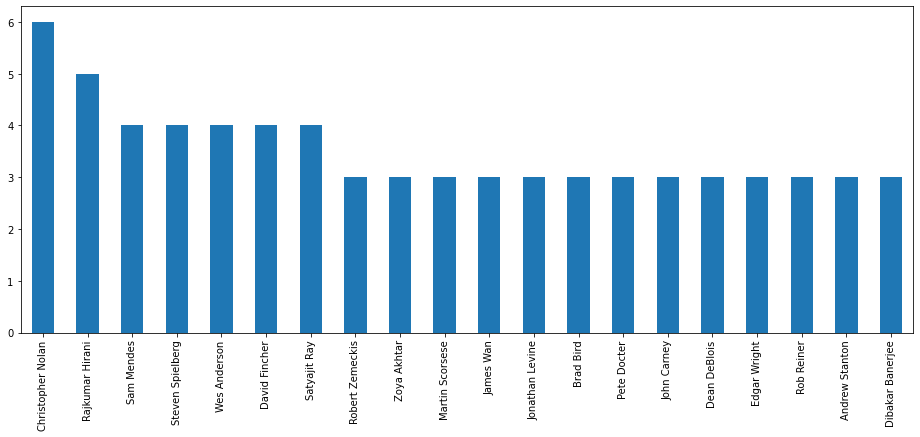

In [8]:
plt.figure(figsize = (16,6))
data_film.Director1.value_counts()[:20].plot(kind = 'bar')
plt.show()

## Bivariate Analysis With Respect to 'Your Rating'
1. Generally follows the same trends as the IMDb ratings. The movies rated the highest tend to be highly rated movies in general. There is a large percentage of movies rated lower that the IMDb user base.
2. The lowest rated movies tend to have longer run times compared to the average movies. The highest rated movies tend to be longer too.
3. Most higher rated movies are more spread out when it comes to year of release. The violin plot shows this better.
4. There is high spread in the popularity of the movies rated higher. Will check relationship using Linear Regression later.

In [9]:
def plot_box_num_biv(df, categ):
    """ Plots Boxplots for all Numerical Columns in Dataframe with respect to a target column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        if categ != item:
            ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 2, i)
            sns.boxplot(x = categ, y = str(item), data = df)
            ax.set_title(item)

    fig.show()

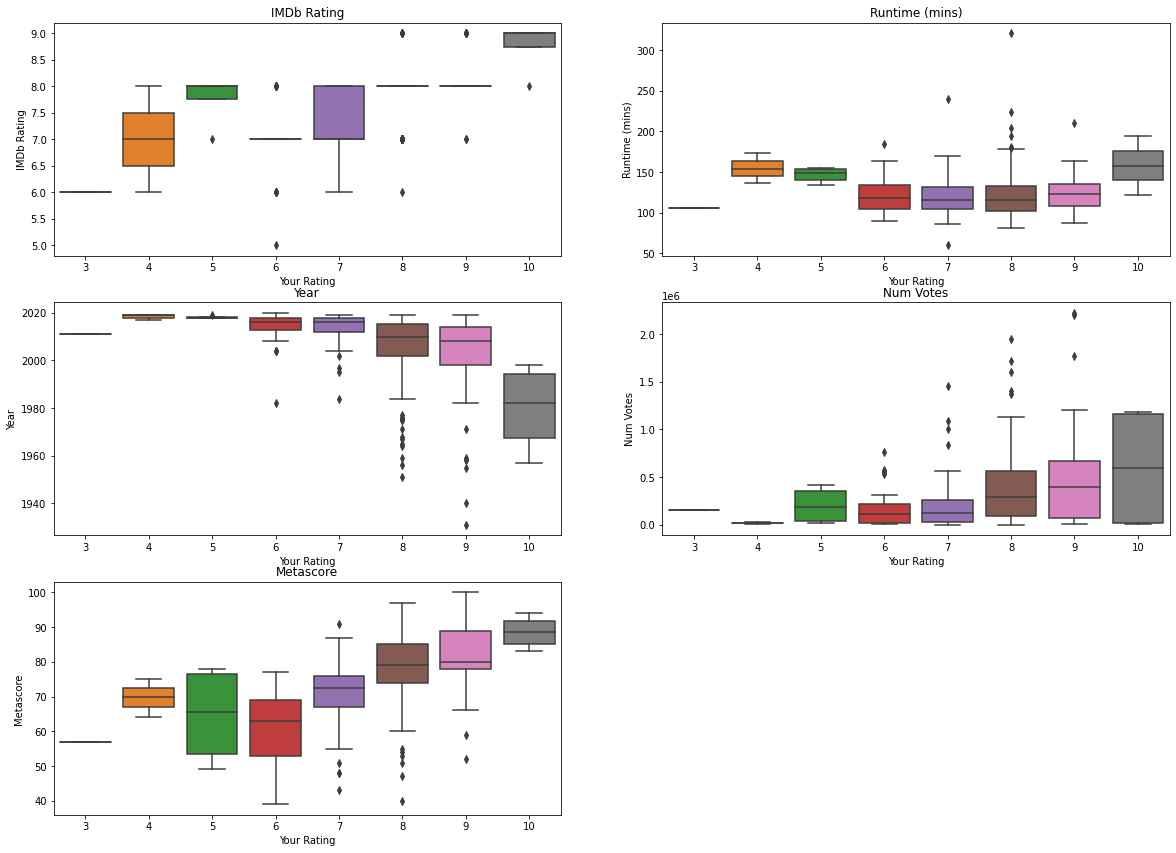

In [10]:
plot_box_num_biv(data_film[num_columns], 'Your Rating')

## Checking Correlation and Associations in Data
### Checking Pearsons Correlation 
The ratings are highly correlated with IMDB User ratings. There is a Decent positive relationship between ratings and Num of votes and negative relationship between rating and year of release. No relationship between runtime and rating.<br>
Since Major awards is a binary column, pearsons r is not particularly meaningful here. 

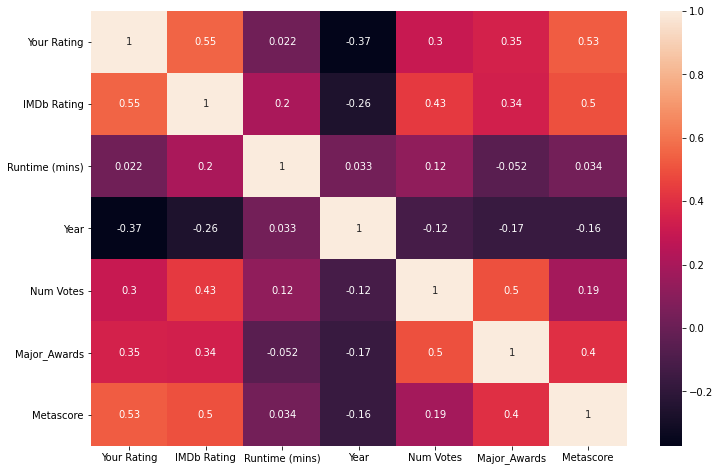

In [478]:
plt.figure(figsize=(12,8))
sns.heatmap(data = data_film.corr(), annot=True)
plt.show()

### Associations for Categorical Data
Pearsons correlation only makes sense for two continuous features. Using Associations(Cramers V) to better visualise relationship between categorical-categorical and categorical-continuous features.
Refer : https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [13]:
from dython.nominal import associations
data_film_corr = data_film.copy()

In [45]:
# Split Date Rated and Date Released columns into Date features
data_film_corr['Date Rated'] = pd.to_datetime(data_film_corr['Date Rated'])
data_film_corr['Release Date'] = pd.to_datetime(data_film_corr['Release Date'])

In [46]:
# Date features
data_film_corr['YearRated'] = data_film_corr['Date Rated'].dt.year
data_film_corr['MonthRated'] =  data_film_corr['Date Rated'].dt.month
data_film_corr['WeekdayRated'] = data_film_corr['Date Rated'].dt.weekday
data_film_corr['QuarterRated'] = data_film_corr['Date Rated'].dt.quarter

# for release year
data_film_corr['YearReleased'] = data_film_corr['Release Date'].dt.year
data_film_corr['MonthReleased'] =  data_film_corr['Release Date'].dt.month
data_film_corr['WeekdayReleased'] = data_film_corr['Release Date'].dt.weekday
data_film_corr['QuarterReleased'] = data_film_corr['Release Date'].dt.quarter

In [47]:
# Drop useless columns
data_film_corr.drop(['Title', 'URL', 'Title Type', 'Date Rated', 'Genres', 'Release Date', 'Directors', 'Year'], axis = 1, inplace=True)

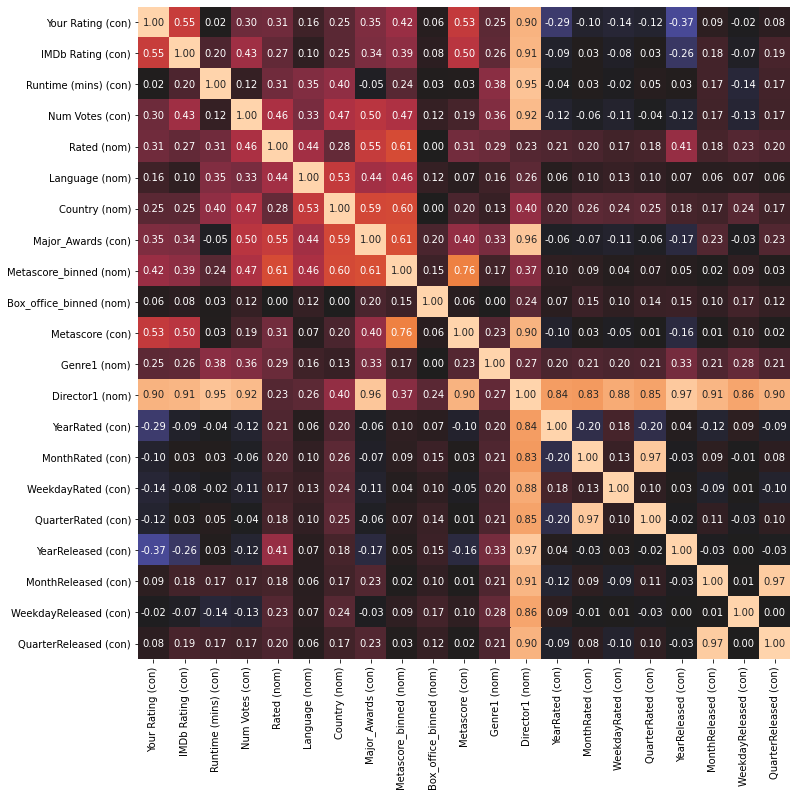

In [52]:
# Using cramers V for categorical-categorical associations
def associations_data():
    associations(data_film_corr,nominal_columns='auto', mark_columns=True, figsize=(12,12), cbar=False)
    
associations_data()

In [74]:
num_columns = data_film_corr.select_dtypes([np.number]).columns.to_list()

## Linear Regression Plots to check If there is a Linear Relationships between Your Rating and Other Quantitaive Vars., Comparison with IMDb Users.
0. A strong relationship is not expected between Your Ratings (sample) and IMDb Ratings (population), this is backed up by the first plot. But this is not of interest as we want to know which features contribute most to the Ratings and whether there is significant difference between the author and the IMDB Population.
1. There is a Strong Positive Linear Relationship between IMDb user Ratings and My Ratings, not significantly different ratings.
2. No Significant Relationship linear relationship between runtime and Your rating.Difference compared to ratings given by IMDb users but there are leverage points.
3. Weak negative relationship between Year of release and Your Rating, stronger than other IMDb users , author favors older movies. Also seen in correlation matrix.
4. Appears to be a weak positive relationship between popularity (Num of votes) and Your rating. Some high leverage points. Comparing with Rating by IMDb users, this relationship appears to be extremely similar. Good movies tend to be popular. 
5. Your ratings has a stronger relationship with Metascore than IMDb users. Critically acclaimed movies liked more.
6. Using robust linear regression to consider outliers deosn't change the results, very computationally expensive. 

In [82]:
def plot_lin_num_biv(df):
    """ Plots Linear Regression best fit lines for all Numerical Columns in Dataframe with respect your rating column.
    """
    fig = plt.figure()
    fig.set_figheight(75)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot((len(df.select_dtypes([np.number]).columns.to_list())), 2, i+1)
        sns.regplot(y = 'Your Rating', x = str(item), data = df, label = 'Your Ratings')#, robust=True)
        sns.regplot(y = 'IMDb Rating', x = str(item), data = df, label = 'IMDb Ratings')#, robust= True)
        ax.legend()
        ax.set_ylabel('Rating')
        ax.set_title('IMDb Rating, Your Rating - ' + item)
    fig.savefig('Graphs/Linear_rel.jpg')
    fig.show()

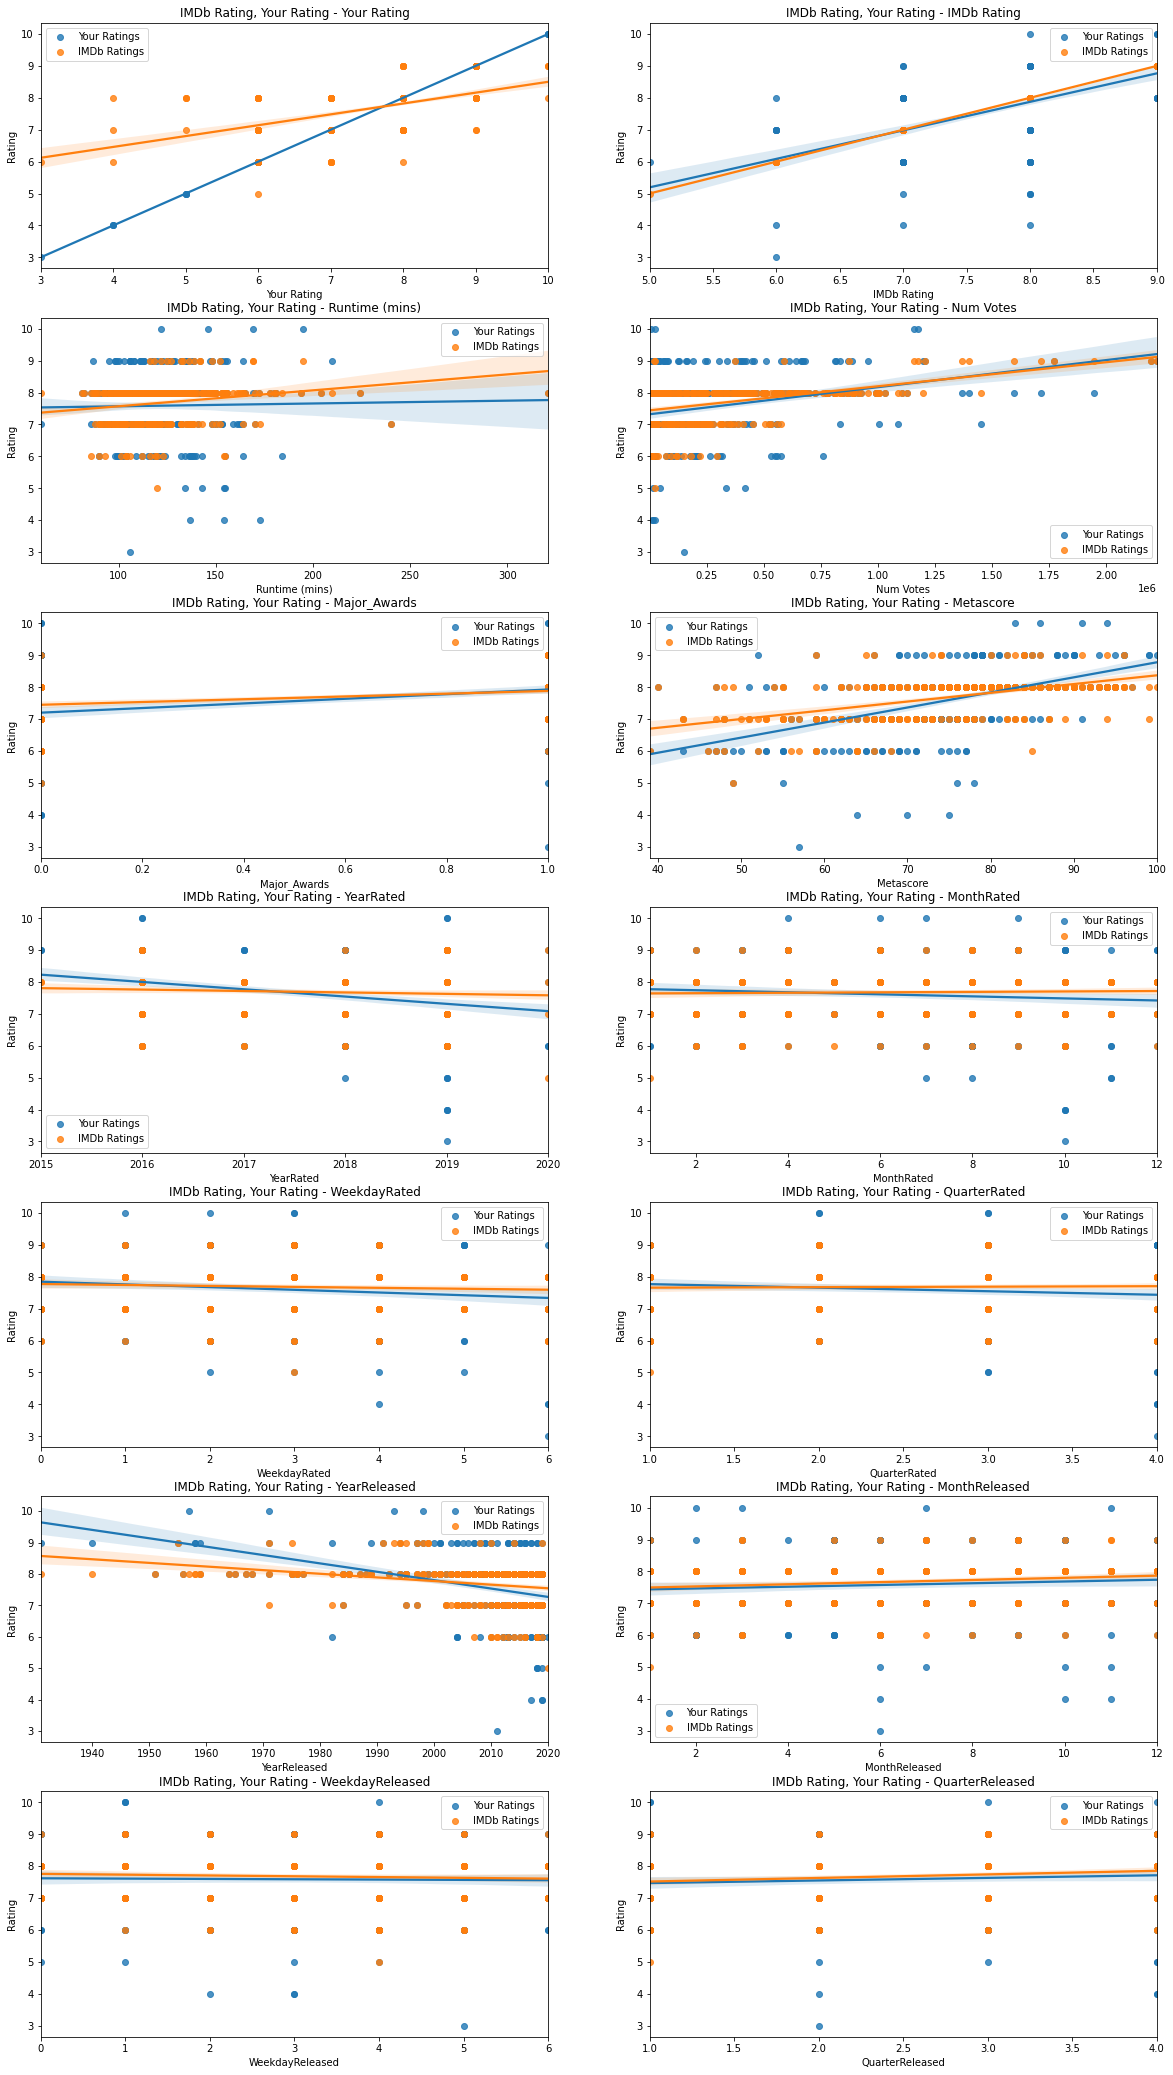

In [83]:
plot_lin_num_biv(data_film_corr[num_columns])

## 2. Clustering. Procedure - Following the Google Machine Learning Course Workflow
1. <b>Prepare Data</b> - Scaling the data is essential for the squared euclidean distance similarity metric used by the algorithm. Also, making sure  all the data is quantitative for k-means etc., one-hot encoded qualitative data doesn't make sense for euclidean distance. Options include, normalisation/standardising the data when you have less data. Log transforming skewed data. Quantile transforming your data when you have abundant data or have extremely weird distributions like an extremely disconnected multimodal distribution and when you explicitly know that the data doesn't come from a normal distribution.
2. <b>Create Similarity Metric </b>- Before a clustering algorithm can group data, it needs to know how similar pairs of examples are. You quantify the similarity between examples by creating a similarity metric. Creating a similarity metric requires you to carefully understand your data and how to derive similarity from your features.  You can create a manual similarity metric for simple data - like numerical difference between shoe sizes. When your data becomes complex enough, you won’t be able to create a manual measure. That’s when you switch to a <b>supervised similarity measure</b>, where a supervised machine learning model calculates the similarity.<br>
For <b>Manual Similarity </b>- RMSE for multiple quantitative vars. For Categorical data (Univalent can have a single value, Multivalent can have multiple values like genre here). For univalent simply 1 for similar, 0 for not, for multivalent use something like Jaccard similarity - which is the ratio of common values.<br>
Then use these encoded similarities in the RMSE formula $\sqrt{(S1^2 + S2^2 + .... SN^2)/N}$ <br>
But the problem with this approach is the fact that we're giving equal weightage to each feature, categorical encoding are also given equal weightage etc. <br>
<b>Supervised Similarity Measure </b> - Reduce the feature data to representations called embeddings, and then compare the embeddings. Embeddings are generated by training a supervised deep neural network (DNN) on the feature data itself. The embeddings map the feature data to a vector in an embedding space. Autoencoders, DNNs used here.
3. <b>Run Clustering Algorithm </b> - A clustering algorithm uses the similarity metric to cluster data. 
4. <b> Interpret Results and Adjust </b>- Checking the quality of your clustering output is iterative and exploratory because clustering lacks “truth” that can verify the output. You verify the result against expectations at the cluster-level and the example-level. Improving the result requires iteratively experimenting with the previous steps to see how they affect the clustering.<br>
Multiple ways to do this, one is the<b> elbow method on the sum of squared error </b>or inertia using the model, another is <b>silhoutte analysis </b>which studies the separation distance between the resulting clusters. Displays a measure of how close each point in a cluster is to another cluster (range -1,1) where 1 indicates the sample is far away from neighbouring clusters and width of the plot of clusters silhouette score along with a line for average silhouette score is a good way to measure distinctness of clusters. <b>Cluster cardinality</b> - The number of examples per cluster. Investigate outliers. <b>Cluster magnitude</b> - Cluster magnitude is the sum of distances from all examples to the centroid of the cluster. Investigate anomaly. <b>Magnitude vs. Cardinality </b>Notice that a higher cluster cardinality tends to result in a higher cluster magnitude, which intuitively makes sense. Clusters are anomalous when cardinality doesn't correlate with magnitude relative to the other clusters. Find anomalous clusters by plotting magnitude against cardinality.
<b>Performance of downstream system </b> Since clustering output is often used in downstream ML systems, check if the downstream system’s performance improves when your clustering process changes. Done here later, is a form of target leakage though.


# 2.A. K-Means Clustering (Using Only Continuous Numerical Data)
1. K-Means is a centroid based clustering algorithm that finds distinct clusters on the basis of the Euclidean distance. Used elbow method with within-cluster sum-of-squares and silhoutte score to assess quality of clusters. Finally clusters visualised using T-SNE. 
2. Just 6 Numerical Features, might not be enough to find meaningful clusters.
3. K-Means has O(nk) complexity with k being the number of clusters and n is the number of points.
4. K-Means finds clusters of roughly circular distributions, so data with outliers might not be suitable to use with this model. This dataset might fall into that category. Still trying.

#### 1. Prepare the data
Clustering requires data to be standardised/scaled since the Euclidean distance is being used to calculate the centroids and form the clusters.<br>
Handling Missing Data - If the examples with missing values are small in number just remove them, else you can use other ML models to estimate these values, common imputation methods work too.<br>
<b> Do not assign a missing label in Clustering </b>
The problem of missing data is not specific to clustering. However, in supervised learning, you may simply assign an "unknown" value to the feature. However, you cannot use an "unknown" value when designing a similarity measure because you have no way to quantify the similarity between "unknown" and any known value.
0. Min-Max scaling all features would get all features in the same scale and preserve difference between distributions but the featurs come from different scales, this is known. This gives equal weightage to all features.(Not desirable - Tried it, gives Rubbish clusters.)
2. Standardising all features would center the features at mean 0 and stdev 1, this gives appropriate weight to features of different scales when compared.(Better, more interesting clusters)<br>
Transformations Performed :
1. Your rating, IMDb Ratings, Metascore, Runtime (mins) look to come from normal distributions. 
2. Year  - Checking with movie lens DB, movies release peaked in the early 2000s then went down, the distributions are somewhat different. - Leave as is.
3. Num Votes has a skew to the right, log transform, assuming normal distribution of popularity - log transform, gives noisier clusters, leave as is.

In [448]:
# Keeping only numerical data
data_film_num = data_film_corr[num_columns]

In [449]:
# Using movies lens dataset to get idea of actual number of movies released per year. 
movie_lens = pd.read_csv('Data/movies_movielens_reference.csv', index_col=0)
# possible title contains brackets, can't do nothing about that.
years = movie_lens.title.str.split('(', expand=True)[1].str.split(')', expand = True)[0]
years.dropna(axis = 0, inplace=True)
year_clean = years[years.str.isnumeric()]
year_clean.replace('8½', 1963, inplace=True)
year_clean = year_clean.astype(int)
# before 1900 should be junk values
year_clean = year_clean.loc[(year_clean > 1900)]

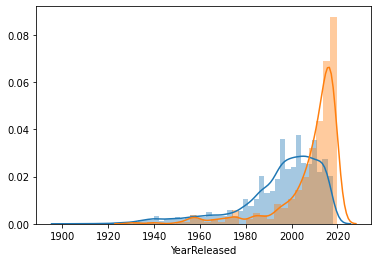

In [230]:
sns.distplot(year_clean)
sns.distplot(data_film_num['YearReleased'])

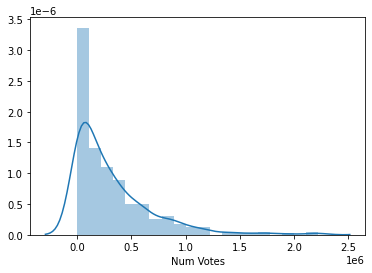

In [231]:
# I watch movies that aren't popular, can log transform to improve normalcy. Doesn't change much.
sns.distplot(data_film_num['Num Votes'])

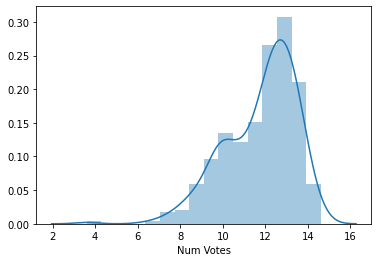

In [232]:
# log transforming 
sns.distplot(np.log(data_film_num['Num Votes']))

In [607]:
# Log transform num votes 
#data_film_num['Num Votes'] = np.log(data_film_num['Num Votes'])

In [452]:
data_film_num.drop(['IMDb Rating', 'Major_Awards', 'YearRated', 'MonthRated', 'WeekdayRated', 'QuarterRated',
                   'MonthReleased', 'WeekdayReleased', 'QuarterReleased'], axis = 1, inplace=True)

In [453]:
# Scaling all data to get it into the same scale.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# When Clustering based on personal ratings and IMDb Users' Ratings : 
#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()
#data_film_scaled =scaler.fit_transform(data_film_num.values)
data_film_scaled = scaler.fit_transform(data_film_num.values)
data_film_scaled_df = pd.DataFrame(data = data_film_scaled,
                                   index = data_film_num.index,
                                   columns = data_film_num.columns)

In [183]:
# when clustering only based on My ratings - Same weightage to every feature, preserves outliers. - StandardScaler
# when you want to squish outliers in range - MinMaxScaler
# when clustering only based on My ratings - Same weightage to every feature, ignoring outliers. - RobustScaler

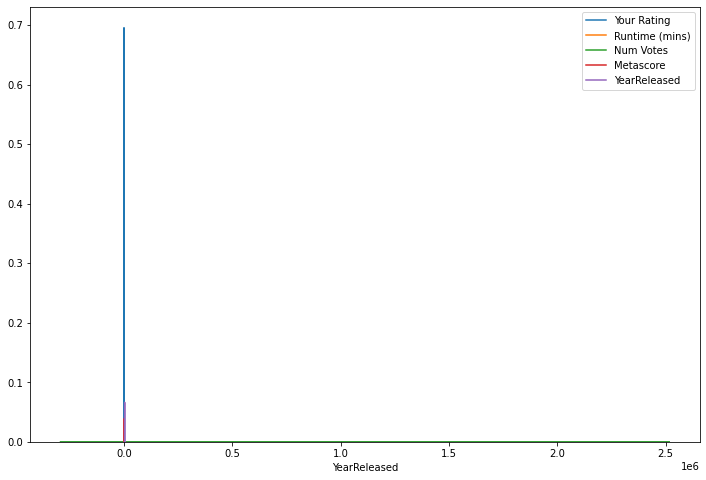

In [177]:
# original scale
plt.figure(figsize=(12, 8))
for item in data_film_num.columns:
    sns.distplot(data_film_num[item], label = item, hist = False)
plt.legend()
plt.show()

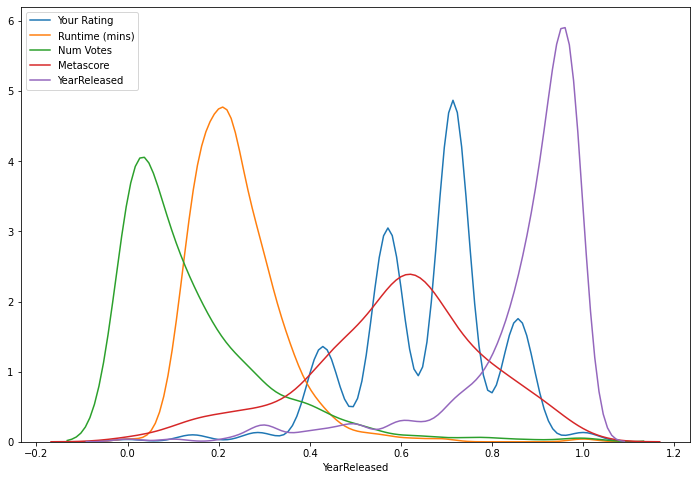

In [182]:
# min-max scaling
plt.figure(figsize=(12, 8))
for item in data_film_scaled_df.columns:
    sns.distplot(data_film_scaled_df[item], label = item, hist = False)
plt.legend()
plt.show()

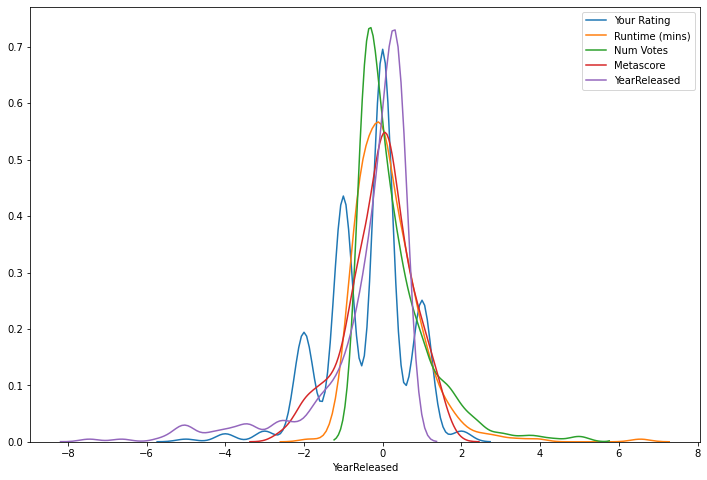

In [178]:
# Robust scaling
plt.figure(figsize=(12, 8))
for item in data_film_scaled_df.columns:
    sns.distplot(data_film_scaled_df[item], label = item, hist = False)
plt.legend()
plt.show()

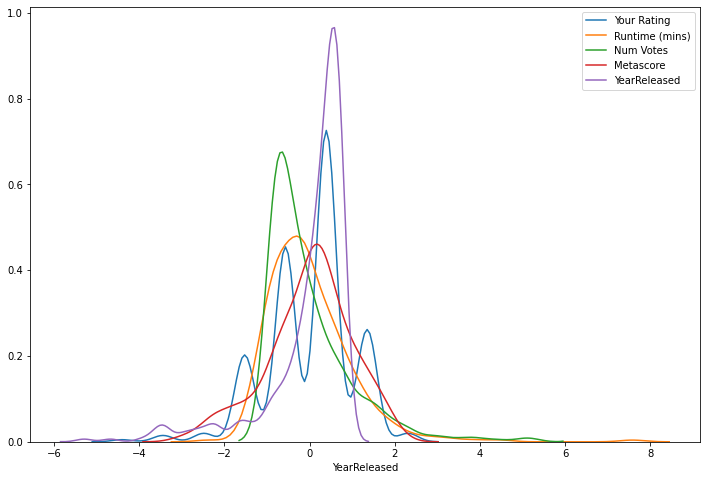

In [180]:
# Standardised features
plt.figure(figsize=(12, 8))
for item in data_film_scaled_df.columns:
    sns.distplot(data_film_scaled_df[item], label = item, hist = False)
plt.legend()
plt.show()

### Visualizing the Scaled High dimensional data using T-SNE
Some clusters are visible by eye in the tsne output of the scaled data, lets see if the Clustering algorithm picks this up.<br>
Dropping IMDb users' ratings, need to find clusters in my data right.

In [460]:
from sklearn.manifold import TSNE
embed_scale = TSNE(n_components=2).fit_transform(data_film_scaled_df)

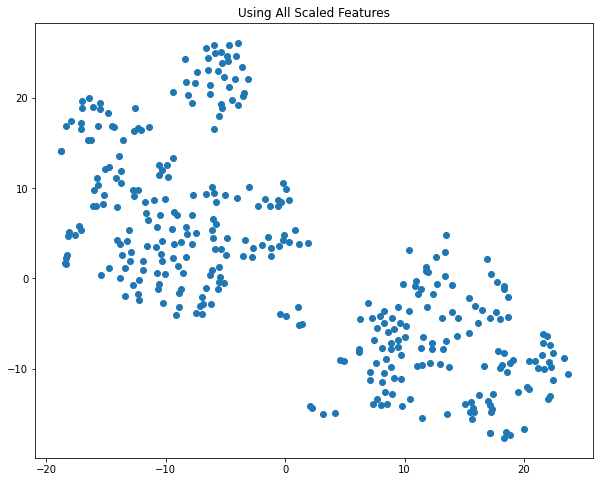

In [461]:
plt.figure(figsize=(10,8))
plt.title('Using All Scaled Features')
plt.scatter(embed_scale[:,:1],embed_scale[:,1:])

## Fitting Kmeans - Clustering Using Numerical preprocessed Data

### Finding Optimal Number of Clusters - Using Elbow Method and SSE Score, Silhouette score Analysis.
1. An Elbow somewhat appears around 10 clusters - not obvious though.
2. Average silhoutte score is highest around the same region before slowly increasing.(Aournd 0.20, clusters are not of high quality).

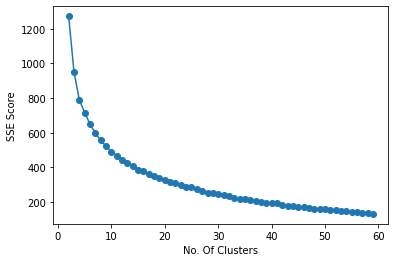

In [462]:
# calculate distortion for a range of number of cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distortions = []
sil_score = []
for i in range(2,60):
    cluster_film = KMeans(n_clusters = i, n_init=10, max_iter= 100, n_jobs=-1).fit(data_film_scaled_df)
    distortions.append(cluster_film.inertia_)
    sil_score.append(silhouette_score(data_film_scaled_df, cluster_film.labels_, metric='euclidean'))
    
plt.xlabel('No. Of Clusters')
plt.ylabel('SSE Score')
plt.plot(range(2, 60), distortions, marker='o')
#plt.savefig('Graphs/Clusters_SSE_plot.jpg')

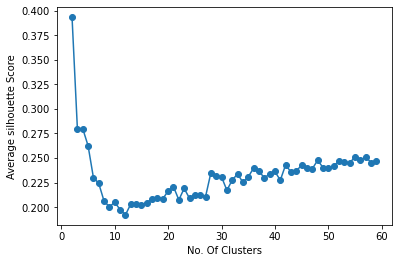

In [463]:
plt.xlabel('No. Of Clusters')
plt.ylabel('Average silhouette Score')
plt.plot(range(2, 60), sil_score, marker='o')
plt.show()

In [464]:
cluster_film = KMeans(n_clusters = 3, n_init=10, max_iter= 100).fit(data_film_scaled_df)
pred_film = cluster_film.labels_

In [465]:
# Creating Dataframe with T-SNE Embeddings and clusters
embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})

In [466]:
pd.DataFrame(data = scaler.inverse_transform(cluster_film.cluster_centers_), columns=data_film_scaled_df.columns)

Your Rating  Runtime (mins)      Num Votes  Metascore  YearReleased
0     8.294118      117.852941  261226.000000  79.117647   1970.411765
1     8.241176      124.717647  470889.841176  80.882353   2010.135294
2     6.631206      120.631206  144580.205674  66.241135   2014.368794

### Lets Place the cluster labels back into dataframe and check which Movies got Clustered Together.

In [467]:
data_film_orig['Cluster_k_means'] = pred_film
# saving clusters.
#data_film_orig['Cluster_k_means_compare'] = pred_film
#data_film_orig.to_csv('Data/Clusters_from_k_means_pca.csv')

# Visualizing and Analyzing the Clusters
1. Fairly Distinct clusters formed in the first case, 
3. Limitation of K-means, Centroid based clustering can be seen, it cannot identify clusters of uneven size.
3. Can Try DBScan Clustering for density based clustering for uneven sized clusters.
3. Cluster 3 consitutes of older movies that are highly rated by the user, Cluster 2 is mostly hindi movies not prefereed by the user, Cluster 1 is mostly contemporary critically acclaimed movies preferred by the user - this also includes Hindi movies preferred by the user. Cluster 0 is contemporary popular movies rated average by the user.
4. The results with the IMDB user ratings included is much more difficult to interpret. 

In [208]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)

import plotly.graph_objects as go

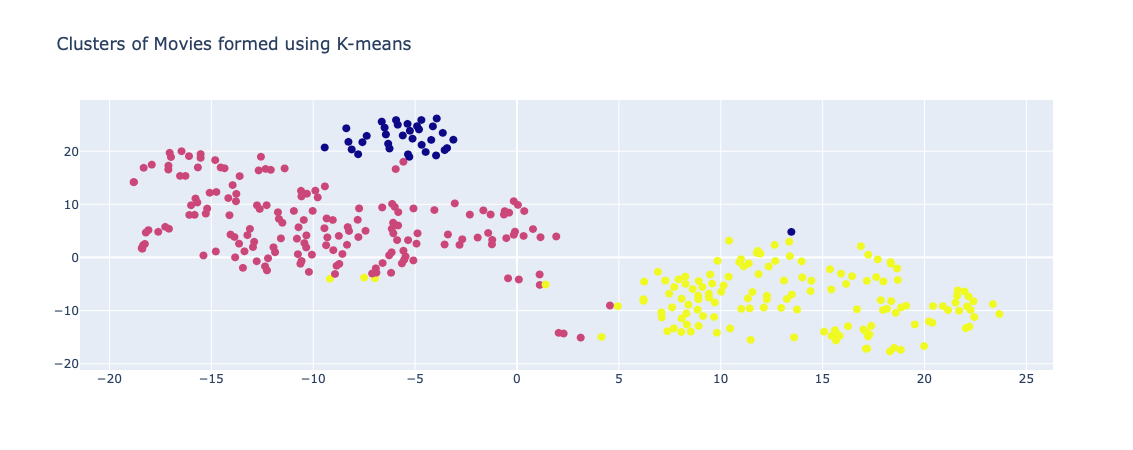

In [468]:
# to get legend with cluster names, will need to set up seperate traces for each cluster.t
trace0 = go.Scatter(x = embed_df['ax1'],
                    y = embed_df['ax2'],
                   mode = 'markers',
                   marker=dict(size = 8, color=embed_df['clusters']),
                   text=data_film_orig['Title'] + ', Cluster : ' + data_film_orig.Cluster_k_means.astype('str'))
#trace0.showlegend = True
data = [trace0]
layout = dict(title = 'Clusters of Movies formed using K-means',)
fig = dict(data = data, layout = layout)

iplot(fig)

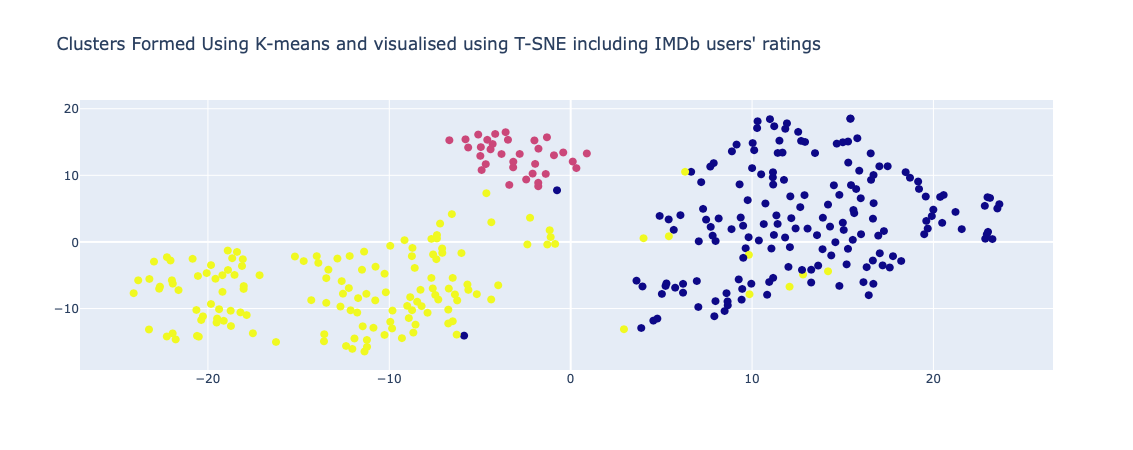

In [241]:
# to get legend with cluster names, will need to set up seperate traces for each cluster.t
trace0 = go.Scatter(x = embed_df['ax1'],
                    y = embed_df['ax2'],
                   mode = 'markers',
                   marker=dict(size = 8, color=embed_df['clusters']),
                   text=data_film_orig['Title'] + ', Cluster : ' + data_film_orig.Cluster_k_means_compare.astype('str'))
#trace0.showlegend = True
data = [trace0]
layout = dict(title = 'Clusters Formed Using K-means and visualised using T-SNE including IMDb users\' ratings')
fig = dict(data = data, layout = layout)

iplot(fig)

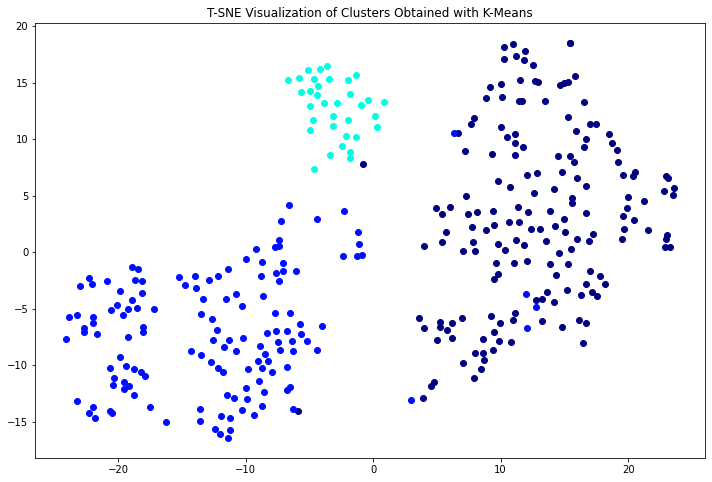

In [211]:
grouped_df = data_film_orig.groupby(['Cluster_k_means'])
embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})
#embed_pc_df = pd.DataFrame({'ax1': embed_pc[:,:1].ravel(), 'ax2': embed_pc[:,1:].ravel(), 'clusters': pred_film})
grouped_df_pc = embed_df.groupby('clusters')
plt.figure(figsize = (12,8))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 1, 10))))
for i in range(3):
    plt.scatter(grouped_df_pc.get_group(i).ax1.tolist(), grouped_df_pc.get_group(i).ax2.tolist(), label = i)
plt.title('T-SNE Visualization of Clusters Obtained with K-Means')
#plt.savefig('Graphs/Cluster_formed.jpg')
plt.show()

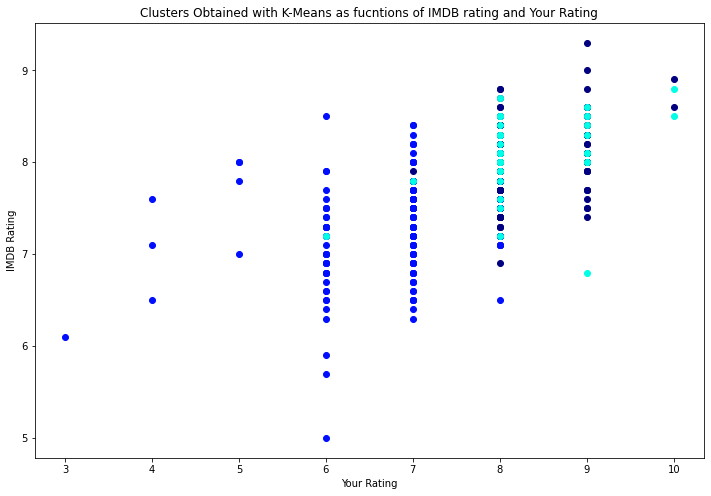

In [212]:
grouped_df = data_film_orig.groupby(['Cluster_k_means'])
#embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})
#embed_pc_df = pd.DataFrame({'ax1': embed_pc[:,:1].ravel(), 'ax2': embed_pc[:,1:].ravel(), 'clusters': pred_film})
#grouped_df_pc = embed_df.groupby('clusters')
plt.figure(figsize = (12,8))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 1, 10))))
for i in range(3):
    plt.scatter(grouped_df.get_group(i)['Your Rating'].tolist(),
                grouped_df.get_group(i)['IMDb Rating'].tolist(), label = i)
plt.title('Clusters Obtained with K-Means as fucntions of IMDB rating and Your Rating')
plt.xlabel('Your Rating')
plt.ylabel('IMDB Rating')
#plt.savefig('Graphs/Cluster_formed.jpg')
plt.show()

### Investigating Clusters

### Cluster Statistics - 
1. Checking Difference in Mean of Your Rating and IMDb Rating for clusters.
2. Mean difference in Runtime(Length).
3. Median Num Votes(Popularity) as data is Highly Skewed.
4. Median Year of Release.

In [213]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster_k_means'])['Your Rating'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['your_imdb_Rating_Mean_Difference'] = data_film_orig.groupby(['Cluster_k_means'])['Your Rating'].mean() - data_film_orig.groupby(['Cluster_k_means'])['IMDb Rating'].mean()
data_film_cluster_stats['RunTime_Mean_Difference'] = data_film_orig.groupby(['Cluster_k_means'])['Runtime (mins)'].mean() - data_film_orig['Runtime (mins)'].mean()
data_film_cluster_stats['votes_Median_Difference'] = data_film_orig.groupby(['Cluster_k_means'])['Num Votes'].median() - data_film_orig['Num Votes'].median()
data_film_cluster_stats['Year_Median_diff'] = data_film_orig.groupby(['Cluster_k_means'])['Year'].median() - data_film_orig['Year'].median()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)

#### 1 Sample T-Test to compare population your rating and cluster your rating.

In [214]:
# Lets perform 1 sample two-tailed t test between population your rating (data_film) and sample clust_0
from scipy.stats import ttest_1samp

def ttest_1samp_cluster_pop(cluster_number):
    """ Testing to see if there is a significant difference between ratings given to films in cluster and 
    the population (Ratings given to all films).
    Null (h0) - There is no difference. (So, No preference to this cluster.)
    Alternate (h1) - There is a difference, these are rated higher/lower by the user.
    """
    pop_film = data_film['Your Rating'].tolist()
    print(f'Population Mean {np.mean(pop_film)}, degrees of freedom {len(pop_film)}')

    clust_3_sample = grouped_df.get_group(cluster_number)['Your Rating'].tolist()
    print(f'Sample mean {np.mean(clust_3_sample)}, degrees of freedom {len(clust_3_sample)}')

    tstat, pvalue = ttest_1samp(clust_3_sample, np.mean(pop_film))
    print('\nT-Stat for hypothesis test {} and P-value {}'.format(tstat, pvalue))
    print('T-critical for n = {}, alpha = 0.05 , look up in table'.format(len(clust_3_sample)-1))
    if pvalue<0.05:
        print('Statistically significant result, Reject the NUll - \nThere is siginificant difference between ratings given to films in this group and the population.')
    else:
        print('Statistically insignificant result, Failled to reject the null.')

In [215]:
def get_genre_cluster(genre = 'Animation'):
    return data_film_orig.loc[data_film.Genres.str.split(',', expand=True)[0] == genre].sort_values('Cluster')

### 1. Clusters of Interest on the basis of Mean Difference in Rating between Your Rating and IMDb Ratings

In [216]:
# Only Keeping clusters with atleast 3 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]

In [217]:
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  \
Cluster_k_means                                            
1                  141                         -0.594326   
2                   34                          0.220588   
0                  170                          0.299412   

                 RunTime_Mean_Difference  votes_Median_Difference  \
Cluster_k_means                                                     
1                              -1.739809                -111450.0   
2                              -4.518073                 -13266.5   
0                               2.346633                 162123.5   

                 Year_Median_diff  
Cluster_k_means                    
1                             3.0  
2                           -40.0  
0                            -1.0

### 2. Clusters of Interest on the basis of Mean difference in Runtime(Length).

In [218]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('RunTime_Mean_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  \
Cluster_k_means                                            
2                   34                          0.220588   
1                  141                         -0.594326   
0                  170                          0.299412   

                 RunTime_Mean_Difference  votes_Median_Difference  \
Cluster_k_means                                                     
2                              -4.518073                 -13266.5   
1                              -1.739809                -111450.0   
0                               2.346633                 162123.5   

                 Year_Median_diff  
Cluster_k_means                    
2                           -40.0  
1                             3.0  
0                            -1.0

### 3. Clusters of Interest on the basis of Median Num Votes(Popularity)

In [219]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('votes_Median_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  \
Cluster_k_means                                            
1                  141                         -0.594326   
2                   34                          0.220588   
0                  170                          0.299412   

                 RunTime_Mean_Difference  votes_Median_Difference  \
Cluster_k_means                                                     
1                              -1.739809                -111450.0   
2                              -4.518073                 -13266.5   
0                               2.346633                 162123.5   

                 Year_Median_diff  
Cluster_k_means                    
1                             3.0  
2                           -40.0  
0                            -1.0

### 4. Clusters of Interest on the basis of Median Year of Release.

In [220]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Year_Median_diff').head(5)

Count  your_imdb_Rating_Mean_Difference  \
Cluster_k_means                                            
2                   34                          0.220588   
0                  170                          0.299412   
1                  141                         -0.594326   

                 RunTime_Mean_Difference  votes_Median_Difference  \
Cluster_k_means                                                     
2                              -4.518073                 -13266.5   
0                               2.346633                 162123.5   
1                              -1.739809                -111450.0   

                 Year_Median_diff  
Cluster_k_means                    
2                           -40.0  
0                            -1.0  
1                             3.0

In [221]:
grouped_df = data_film_orig.groupby(['Cluster_k_means'])

### Statistical Significance of the mean Ratings given to films in clusters compared to overall mean ratings
All Clusters have statistically significant difference to the over population.
1. Cluster 0 - generally preferred movies.
2. Cluster 1 - generally disliked movies.
3. Cluster 2 - generally preferred movies

In [227]:
# by positive rating, cluster 6 and 1.

# CLuster 2 movies preferred.

#grouped_df.get_group(3).head(30)
#grouped_df.get_group(2).describe()
ttest_1samp_cluster_pop(2)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.294117647058824, degrees of freedom 34

T-Stat for hypothesis test 5.414717384345936 and P-value 5.4238931049306455e-06
T-critical for n = 33, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


# 2.B. PCA and K-Means Clustering (Using Encoded Categorical Data)
1. K-Means is a centroid based clustering algorithm that finds distinct clusters on the basis of the Euclidean distance. Multiple one-hot encoded categorical features used, results in a large feature set, which has been reduced using principal components analysis(50% variance). Used elbow method with within-cluster sum-of-squares and silhoutte score to assess quality of clusters. Finally clusters visualised using T-SNE. 
2. <b>Potential problems with this approach</b>, binary categorical columns don't make much sense with Euclidean distance. PCA is a simple linear dimensionality reduction technique, but consensus is out there for use with complex data. Again using PCA on binary categorical data is problematic. 
3. Trying K-modes(categorical features), K-prototype(mixed features) clustering for encoded categorical data next.

### Feature Engineering, Dropping Useless columns, One-hot Encodding Categorical Column like Genre, Director etc.

#### Feature Engineering - One - Hot encode Genre, Directors and Dropping a few Columns, Convert Rated to Numerical

In [274]:
data_film = data_film_backup.copy()
data_film[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7']] = data_film.Genres.str.split(',', expand=True)
data_film.drop(['Genre2','Genre3', 'Genre4','Genre5','Genre6','Genre7'], axis= 1, inplace = True)
# Loss of info by dropping secondary, tertiary genres but will result in duplication, is complex.
# Loss of info, Lee ukreich, ethan and joel coen etc are big loosers. Complex fix later.
data_film[['Director1','Director2','Director3', 'Director4']] = data_film.Directors.str.split(',', expand=True)
data_film.drop(['Director2','Director3', 'Director4'], axis = 1, inplace = True)
data_film.drop(['Genres', 'Directors'], axis = 1, inplace = True)
data_film = pd.get_dummies(data_film, prefix='Genre', columns=['Genre1'])
data_film = pd.get_dummies(data_film, prefix='Director', columns=['Director1'])
data_film[['Rated_Year', 'Rated_month', 'Rated_Day']] = data_film['Date Rated'].str.split('-', expand = True)
data_film.drop(['Rated_month', 'Rated_Day'], axis = 1, inplace = True)
data_film.drop('Date Rated', axis = 1, inplace = True)
data_film[['Release_Year', 'Release_month', 'Release_Day']] = data_film['Release Date'].str.split('-', expand = True)
data_film.drop(['Release_month', 'Release_Day'], axis = 1, inplace = True)
data_film.drop('Release Date', axis = 1, inplace = True)
data_film.drop(['Title Type', 'URL'], axis = 1, inplace = True)
data_film = pd.get_dummies(data_film, prefix='Censor_rating', columns=['Rated'])
#data_film = pd.get_dummies(data_film, prefix='Major_awards', columns=['Major_Awards'])
#data_film = pd.get_dummies(data_film, prefix='Metascore_binned', columns=['Metascore_binned'])
#data_film = pd.get_dummies(data_film, prefix='Box_office_binned', columns=['Box_office_binned'])
data_film = pd.get_dummies(data_film, prefix='Country', columns=['Country'])
data_film = pd.get_dummies(data_film, prefix='Language', columns=['Language'])
data_film.drop(['Metascore_binned'], axis = 1, inplace=True)
data_film.drop(['Box_office_binned'], axis = 1, inplace=True)
data_film.drop(['Title'], axis = 1, inplace=True)
data_film.drop(['Release_Year'], axis = 1, inplace=True)
data_film['Rated_Year'] = data_film['Rated_Year'].astype(int)
data_film.drop(['IMDb Rating'], axis = 1, inplace=True)

## Curse of Dimensionality - Principal Components Analysis to Reduce Dimensionality of Data
301 Features for 345 samples. <br>
Doesn't make sense with encoded categorical data, trying anyway.
Scaling Numerical columns, then concatenating one hot encoded columns and performing PCA.

#### Standardize Data
PCA requires data to be standardised/scaled otherwise the principal components found are basically meaningless due to different scales of features.

In [287]:
from sklearn.preprocessing import StandardScaler
data_film_scaled = RobustScaler().fit_transform(data_film.iloc[:, :4].values)

#### Restoring Indexes And Column Names

In [288]:
data_film_scaled_df = pd.DataFrame(data = data_film_scaled, index = data_film.index, columns = data_film.columns[:4])

In [289]:
data_film_scaled_df  = pd.concat([data_film_scaled_df, data_film.iloc[:, 4:]], axis = 1)

#### Lets Target that 50% Percent of the Variance is explained by the principal components - Explained by 106 Features.

In [290]:
from sklearn.decomposition import PCA

target_variance = 0.9

explained_var_comp = []
for i in range(len(data_film_scaled_df.columns)):
    pca_film = PCA(n_components=i)
    pca_components_film = pca_film.fit_transform(data_film_scaled_df)
    explained_var_comp.append(np.sum(pca_film.explained_variance_ratio_))
    #print(f'Total Explained Variance is {np.sum(pca_film.explained_variance_ratio_)}')
    if np.sum(pca_film.explained_variance_ratio_) > target_variance:
        #print(f'No of Components that explain 50% of Variance: {i}')
        break

print(f'No of Components that explain {target_variance*100}% of Variance: {i}')

No of Components that explain 90.0% of Variance: 23


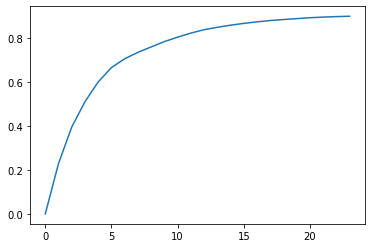

In [291]:
plt.plot(np.arange(len(explained_var_comp)), explained_var_comp)

### Checking important Features for First Principal Component
No single features dominates, which is good.

In [292]:
first_comp = pca_film.components_[4]
# Creating Dataframe for correspoding Columns in original Dataframe
first_comps = pd.DataFrame(zip(first_comp, data_film_scaled_df.columns), columns = ['Weights', 'Features'])
first_comps['abs_weights']=first_comps['Weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False)[:10]

Weights             Features  abs_weights
0   -0.770316          Your Rating     0.770316
3    0.346404            Num Votes     0.346404
2   -0.321518                 Year     0.321518
1    0.212003       Runtime (mins)     0.212003
272 -0.211759           Rated_Year     0.211759
296  0.132354          Country_USA     0.132354
277  0.125629  Censor_rating_PG-13     0.125629
5    0.104908         Genre_Action     0.104908
279 -0.103537      Censor_rating_R     0.103537
12  -0.103283          Genre_Drama     0.103283

In [293]:
list_pca_film = list(pca_components_film)

## Visualizing the High Dimensional data and Principal Components using T-SNE
Some clusters are visible by eye in the tsne output of the pricipal components, lets see if the Clustering algorithm picks this up.

In [ ]:
# Distance metrics - from scipy.spatial.distance import pdist

In [294]:
from sklearn.manifold import TSNE
embed_scale = TSNE(n_components=2).fit_transform(data_film_scaled_df)
embed_pc = TSNE(n_components=2).fit_transform(pca_components_film)

In [ ]:
#data_film_orig.loc[embed_scale[:,1:] == sorted(embed_scale[:,1:])[-1]]

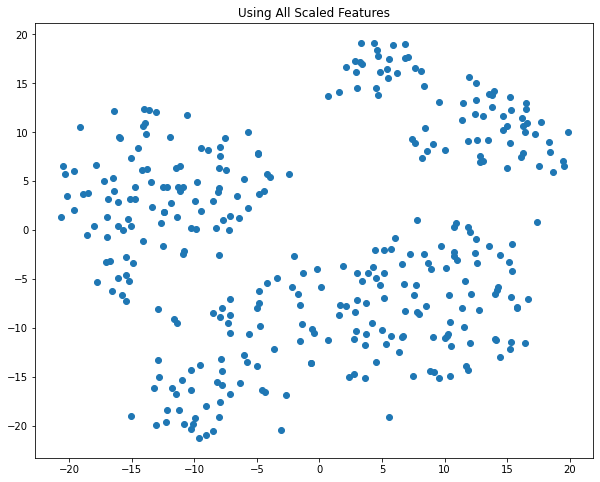

In [295]:
plt.figure(figsize=(10,8))
plt.title('Using All Scaled Features')
plt.scatter(embed_scale[:,:1],embed_scale[:,1:])

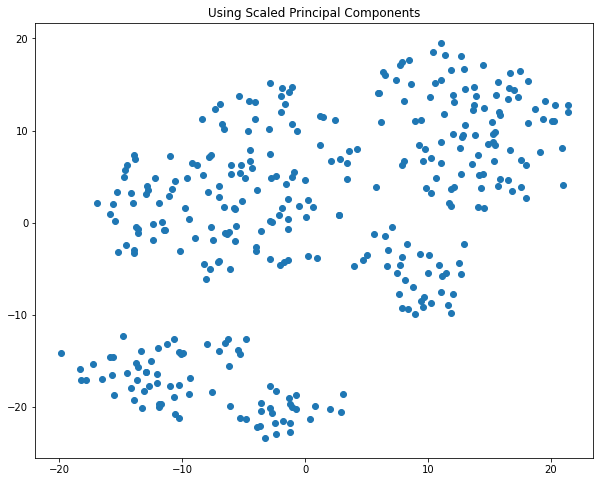

In [296]:
plt.figure(figsize=(10,8))
plt.title('Using Scaled Principal Components')
plt.scatter(embed_pc[:,:1],embed_pc[:,1:])

## Fitting Kmeans - Clustering Using Principal Components

### Finding Optimal Number of Clusters - Using Elbow Method and SSE Score, Silhouette score Analysis.
1. An Elbow is not clear.
2. Average silhoutte score is highest around 5 clusters but is absolutely terrible, makes sense with one-hot encoded features are incredibly sparse.

In [ ]:
#from sklearn.metrics.pairwise import pairwise_distances

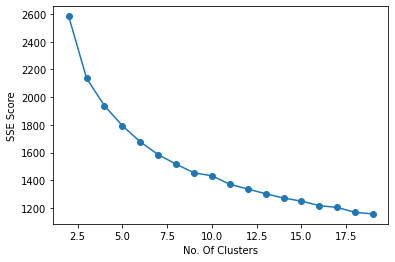

In [297]:
# calculate distortion for a range of number of cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distortions = []
sil_score = []
for i in range(2,20):
    cluster_film = KMeans(n_clusters = i, n_init=10, max_iter= 100, n_jobs=-1).fit(pca_components_film)
    distortions.append(cluster_film.inertia_)
    sil_score.append(silhouette_score(data_film_scaled, cluster_film.labels_, metric='euclidean'))
    
plt.xlabel('No. Of Clusters')
plt.ylabel('SSE Score')
plt.plot(range(2, 20), distortions, marker='o')
#plt.savefig('Graphs/Clusters_SSE_plot.jpg')

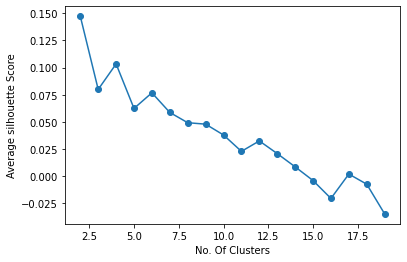

In [298]:
plt.xlabel('No. Of Clusters')
plt.ylabel('Average silhouette Score')
plt.plot(range(2, 20), sil_score, marker='o')

In [299]:
cluster_film = KMeans(n_clusters = 3, n_init=10, max_iter= 100).fit(data_film_scaled)
pred_film = cluster_film.labels_

### Lets Place the cluster labels back into dataframe and check which Movies got Clustered Together.

In [300]:
data_film_orig['Cluster_Categ_PCA'] = pred_film
# saving clustep[rs.
#data_film_orig.to_csv('Data/Clusters_from_k_means_pca.csv')

# Visualizing and Analyzing the Clusters
1. Mostly Small Clusters are being formed, some larger clusters can be seen too. The larger clusters have plenty of overlap.
2. Investigating individual clusters and their silhoutte scores, most large clusters have lower than average silhoutte scores and the clusters with a reasonable size and above average silhoutte score are clusters of films by a particular director.

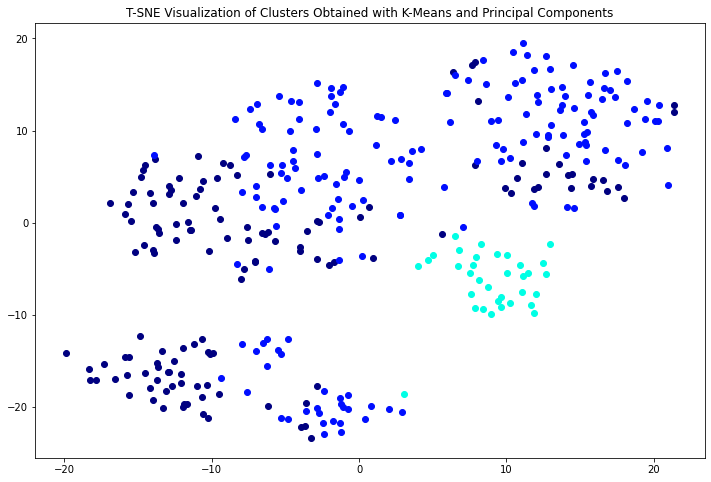

In [301]:
grouped_df = data_film_orig.groupby(['Cluster_Categ_PCA'])
embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})
embed_pc_df = pd.DataFrame({'ax1': embed_pc[:,:1].ravel(), 'ax2': embed_pc[:,1:].ravel(), 'clusters': pred_film})
grouped_df_pc = embed_pc_df.groupby('clusters')
plt.figure(figsize = (12,8))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 1, 10))))
for i in range(3):
    plt.scatter(grouped_df_pc.get_group(i).ax1.tolist(), grouped_df_pc.get_group(i).ax2.tolist(), label = i)
plt.title('T-SNE Visualization of Clusters Obtained with K-Means and Principal Components')
#plt.savefig('Graphs/Cluster_formed.jpg')
plt.show()

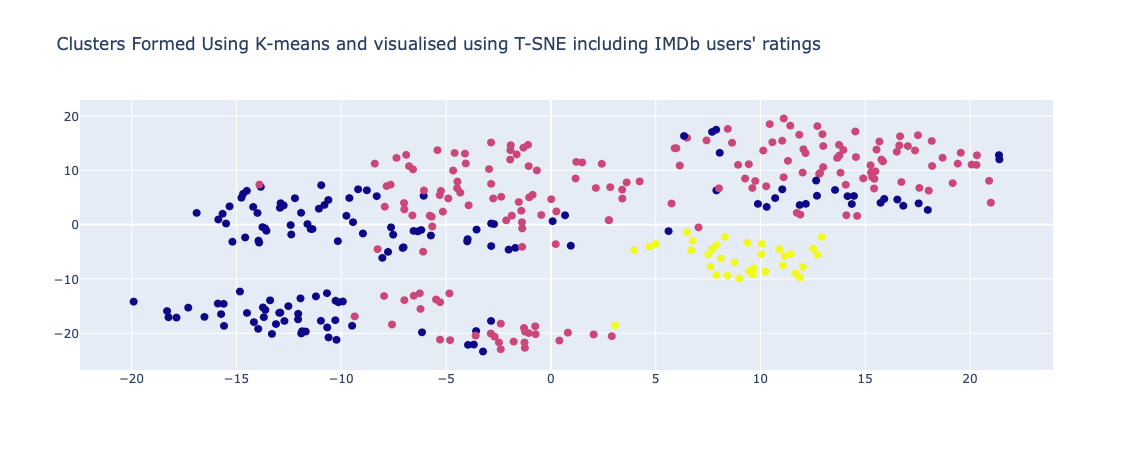

In [302]:
# to get legend with cluster names, will need to set up seperate traces for each cluster.t
trace0 = go.Scatter(x = embed_pc_df['ax1'],
                    y = embed_pc_df['ax2'],
                   mode = 'markers',
                   marker=dict(size = 8, color=embed_pc_df['clusters']),
                   text=data_film_orig['Title'] + ', Cluster : ' + data_film_orig.Cluster_Categ_PCA.astype('str'))
#trace0.showlegend = True
data = [trace0]
layout = dict(title = 'Clusters Formed Using K-means and visualised using T-SNE including IMDb users\' ratings')
fig = dict(data = data, layout = layout)

iplot(fig)

## 2.C. K-Modes for Categorical Columns
Since Euclidean distance is not suitable for categorical columns or encoded categorical columns, trying K-modes that uses Hamming distance metric to find simmilarity between categorical columns, also the cluster centroids are defined using the mode of the members, hence the name. <br>
Just 5 Features, Visualise using T-Sne and Hamming Distance - can't get it to work. Visualizing using TSNE on numerical columns and Euclidean distance, practically maningless to view clusters), much different clusters.

In [303]:
from kmodes import kmodes, kprototypes, util

In [304]:
data_film = data_film_backup.copy()
data_film[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7']] = data_film.Genres.str.split(',', expand=True)
data_film.drop(['Genre2','Genre3', 'Genre4','Genre5','Genre6','Genre7'], axis= 1, inplace = True)
# Loss of info by dropping secondary, tertiary genres but will result in duplication, is complex.
# Loss of info, Lee ukreich, ethan and joel coen etc are big loosers. Complex fix later.
data_film[['Director1','Director2','Director3', 'Director4']] = data_film.Directors.str.split(',', expand=True)
data_film.drop(['Director2','Director3', 'Director4'], axis = 1, inplace = True)
data_film.drop(['Genres', 'Directors'], axis = 1, inplace = True)

In [305]:
data_film_categ = data_film.select_dtypes('object').drop(['Date Rated', 'Title', 'URL', 'Title Type', 'Release Date'], axis = 1)
data_film_categ.drop(['Metascore_binned', 'Box_office_binned'], axis = 1, inplace = True)
data_film_categ.fillna('Not Rated', inplace=True)

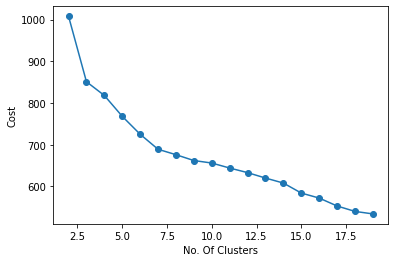

In [306]:
cost = []
for i in range(2,20):
    kmode = kmodes.KModes(n_clusters=i, max_iter=100,
              init='Cao', n_init=1, verbose=10, random_state=None, n_jobs=-1)
    kmode.fit(data_film_categ)
    cost.append(kmode.cost_)
    
plt.xlabel('No. Of Clusters')
plt.ylabel('Cost')
plt.plot(range(2, 20), cost, marker='o')
#plt.savefig('Graphs/Clusters_SSE_plot.jpg')

In [307]:
# 7 looks to be it 

kmode = kmodes.KModes(n_clusters=7, max_iter=100,
              init='Cao', n_init=1, verbose=1, random_state=None, n_jobs=-1)
kmode.fit(data_film_categ)

KModes(n_clusters=7, n_jobs=-1, verbose=1)

In [308]:
data_film_orig['Cluster_K_modes'] = kmode.labels_

In [309]:
kmode.cluster_centroids_

array([['R', 'Multilingual/Foreign', 'USA', 'Comedy', 'Wes Anderson'],
       ['PG-13', 'English', 'USA', 'Drama', 'Robert Zemeckis'],
       ['Not Rated', 'Hindi', 'India', 'Drama', 'Satyajit Ray'],
       ['R', 'English', 'USA', 'Biography', 'Adam McKay'],
       ['PG-13', 'Multilingual/Foreign', 'USA', 'Action',
        'Christopher Nolan'],
       ['PG', 'English', 'USA', 'Animation', 'Dean DeBlois'],
       ['Not Rated', 'Multilingual/Foreign', 'India', 'Comedy',
        'Rajkumar Hirani']], dtype='<U20')

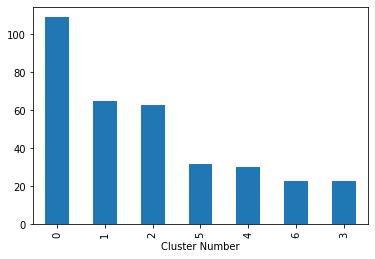

In [310]:
data_film_orig['Cluster_K_modes'].value_counts().plot(kind = 'bar').set(xlabel ='Cluster Number')
plt.show()

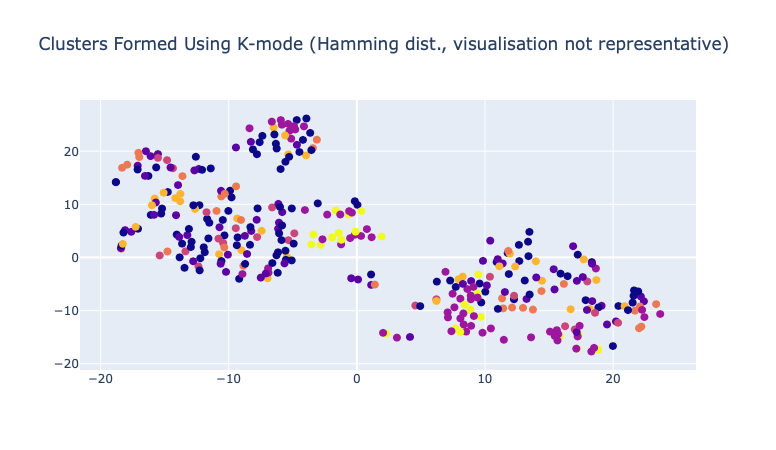

In [469]:
# to get legend with cluster names, will need to set up seperate traces for each cluster.t
trace0 = go.Scatter(x = embed_scale[:,0],
                    y = embed_scale[:,1],
                   mode = 'markers',
                   marker=dict(size = 8, color=data_film_orig.Cluster_K_modes),
                   text=data_film_orig['Title'] + ', Cluster : ' + data_film_orig.Cluster_K_modes.astype('str'))
#trace0.showlegend = True
data = [trace0]
layout = dict(title = 'Clusters Formed Using K-mode (Hamming dist., visualisation not representative)')
fig = dict(data = data, layout = layout)

iplot(fig)

In [312]:
# Lets Display smallest cluster. 
# Centroid : ['R', 'English', 'USA', 'Biography', 'Adam McKay'],
data_film_orig[data_film_orig.Cluster_K_modes == 3].head(5)

Your Rating  Date Rated                 Title  \
tt0114369            8  2019-07-02                 Se7en   
tt1156398            8  2016-11-26            Zombieland   
tt0133093            8  2019-06-28            The Matrix   
tt1431045            8  2016-04-27              Deadpool   
tt1485796            7  2019-08-23  The Greatest Showman   

                                             URL Title Type  IMDb Rating  \
tt0114369  https://www.imdb.com/title/tt0114369/      movie          8.6   
tt1156398  https://www.imdb.com/title/tt1156398/      movie          7.6   
tt0133093  https://www.imdb.com/title/tt0133093/      movie          8.7   
tt1431045  https://www.imdb.com/title/tt1431045/      movie          8.0   
tt1485796  https://www.imdb.com/title/tt1485796/      movie          7.6   

           Runtime (mins)  Year                             Genres  Num Votes  \
tt0114369             127  1995    Crime, Drama, Mystery, Thriller    1368813   
tt1156398              88  2009  Adventure, Comedy, Horror, Sci-Fi     501456   
tt0133093             136  1999                     Action, Sci-Fi    1597353   
tt1431045             108  2016  Action, Adventure, Comedy, Sci-Fi     867007   
tt1485796             105  2017          Biography, Drama, Musical     218453   

           ... Rated Language Country Major_Awards Metascore_binned  \
tt0114369  ...     R  English     USA          1.0              mid   
tt1156398  ...     R  English     USA          0.0             high   
tt0133093  ...     R  English     USA          1.0             high   
tt1431045  ...     R  English     USA          1.0              mid   
tt1485796  ...    PG  English     USA          1.0              mid   

           Box_office_binned Cluster_k_means Cluster_k_means_compare  \
tt0114369                NaN               0                       0   
tt1156398                NaN               0                       0   
tt0133093                NaN               0                       0   
tt1431045                NaN               0                       0   
tt1485796             500Mil               1                       2   

           Cluster_Categ_PCA  Cluster_K_modes  
tt0114369                  1                3  
tt1156398                  1                3  
tt0133093                  1                3  
tt1431045                  1                3  
tt1485796                  0                3  

[5 rows x 22 columns]

## 2.D. K Prototypes
Is a hybrid approach of K-means, K-modes, don't completely understand how this works. Takes in both Numerical and categorical columns, specify where the categorical columns start. Visualizing using TSNE on numerical columns and Euclidean distance, practically maningless to view clusters).<br>
Analysing the clusters manually and with their distributions, the method provides the best representation of the preferences of the movies by the user.

In [313]:
from kmodes import kprototypes, util

In [314]:
kprot = kprototypes.KPrototypes(n_clusters=8, max_iter=100, init='Huang',
                        n_init=10, gamma=None, verbose=0, random_state=None, n_jobs=1)

In [315]:
film_combined_data = np.concatenate((data_film_scaled, data_film_categ), axis = 1)

In [316]:
# specifying which columns are categorical 
kprot.fit(X = film_combined_data, categorical=[4, 5, 6, 7, 8])

KPrototypes(gamma=0.5495172293680811)

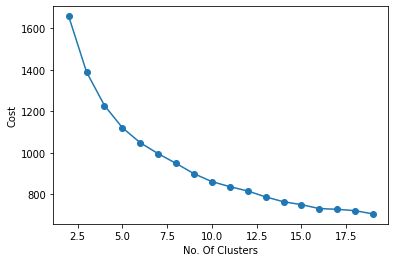

In [317]:
cost = []
for i in range(2,20):
    cluster = kprototypes.KPrototypes(n_clusters=i, max_iter=100, init='Huang',
                        n_init=10, gamma=None, verbose=0, random_state=None, n_jobs=-1)
    cluster.fit(X = film_combined_data, categorical=[4, 5, 6, 7, 8])
    cost.append(cluster.cost_)
    
plt.xlabel('No. Of Clusters')
plt.ylabel('Cost')
plt.plot(range(2, 20), cost, marker='o')
#plt.savefig('Graphs/Clusters_SSE_plot.jpg')

In [321]:
# Selecting 10 clusters 
cluster = kprototypes.KPrototypes(n_clusters=5, max_iter=100, init='Huang',
                                  n_init=10, gamma=None, verbose=0, random_state=None, n_jobs=-1)
cluster.fit(X = film_combined_data, categorical=[4, 5, 6, 7, 8])

KPrototypes(gamma=0.5495172293680811, n_clusters=5, n_jobs=-1)

In [322]:
data_film_orig['Cluster_K_Prototype'] = cluster.labels_

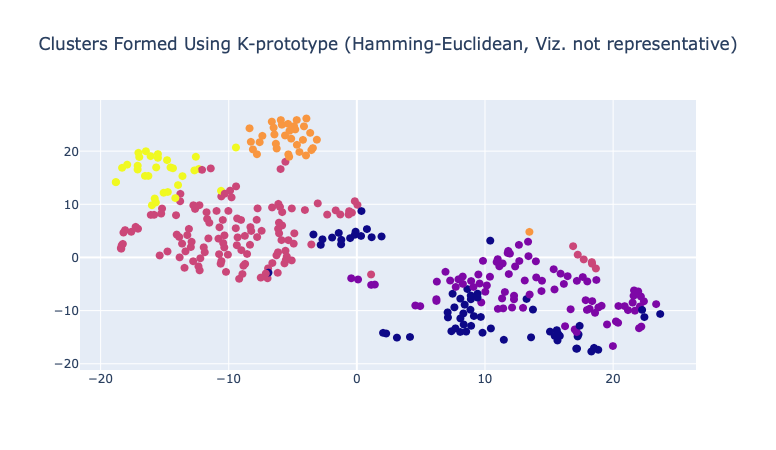

In [470]:
# to get legend with cluster names, will need to set up seperate traces for each cluster.t
trace0 = go.Scatter(x = embed_scale[:,0],
                    y = embed_scale[:,1],
                   mode = 'markers',
                   marker=dict(size = 8, color=data_film_orig.Cluster_K_Prototype),
                   text=data_film_orig['Title'] + ', Cluster : ' + data_film_orig.Cluster_K_Prototype.astype('str'))
#trace0.showlegend = True
data = [trace0]
layout = dict(title = 'Clusters Formed Using K-prototype (Hamming-Euclidean, Viz. not representative)')
fig = dict(data = data, layout = layout)

iplot(fig)

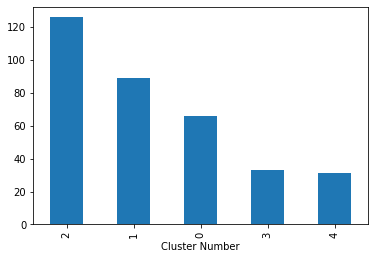

In [324]:
# Cluster sizes 
data_film_orig['Cluster_K_Prototype'].value_counts().plot(kind = 'bar').set(xlabel ='Cluster Number')
plt.show()

In [325]:
# Centroid of first cluster
np.concatenate((cluster.cluster_centroids_[0][2],cluster.cluster_centroids_[1][2]))

array(['0.24603174603174602', '-0.09037378392217107',
       '-0.09956709956709926', '0.3051658498020471', 'R',
       'Multilingual/Foreign', 'USA', 'Drama', 'Wes Anderson'],
      dtype='<U32')

In [326]:
# Cluster Stats
data_film_cluster_stats = data_film_orig.groupby(['Cluster_K_Prototype'])['Your Rating'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['your_imdb_Rating_Mean_Difference'] = data_film_orig.groupby(['Cluster_K_Prototype'])['Your Rating'].mean() - data_film_orig.groupby(['Cluster_K_Prototype'])['IMDb Rating'].mean()
data_film_cluster_stats['RunTime_Mean_Difference'] = data_film_orig.groupby(['Cluster_K_Prototype'])['Runtime (mins)'].mean() - data_film_orig['Runtime (mins)'].mean()
data_film_cluster_stats['votes_Median_Difference'] = data_film_orig.groupby(['Cluster_K_Prototype'])['Num Votes'].median() - data_film_orig['Num Votes'].median()
data_film_cluster_stats['Year_Median_diff'] = data_film_orig.groupby(['Cluster_K_Prototype'])['Year'].median() - data_film_orig['Year'].median()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)

In [327]:
data_film_cluster_stats.sort_values('your_imdb_Rating_Mean_Difference').tail(5)

Count  your_imdb_Rating_Mean_Difference  \
Cluster_K_Prototype                                            
0                       66                         -0.663636   
1                       89                         -0.511236   
4                       31                         -0.045161   
3                       33                          0.242424   
2                      126                          0.454762   

                     RunTime_Mean_Difference  votes_Median_Difference  \
Cluster_K_Prototype                                                     
0                                  23.628986                -181470.5   
1                                 -11.371014                 -14632.0   
4                                  16.241889                 884282.0   
3                                  -4.461924                 -16223.0   
2                                  -7.172602                 102205.5   

                     Year_Median_diff  
Cluster_K_Prototype                    
0                                 3.0  
1                                 3.0  
4                               -14.0  
3                               -42.0  
2                                 1.0

In [329]:
grouped_df = data_film_orig.groupby(['Cluster_K_Prototype'])

### Checking the cluster with the highest positive deviation in rating
Statistically significant difference (A bit useless with large sample sizes).<br>
Visualising the distributions you can see that these movies get a higher score compared both to Ratings given to entire dataset and Ratings given to the same movies by other IMDb users.

In [330]:
# Centroid for 2: array([ 0.94218709,  0.25460833,  0.31922191, -0.305434 ,'R', 'Multilingual/Foreign',
# 'USA', 'Drama', 'Alex Garland'])
#grouped_df.get_group(2).head(5)
ttest_1samp(grouped_df.get_group(2)['Your Rating'],data_film_orig['Your Rating'].mean())

Ttest_1sampResult(statistic=16.384499330473563, pvalue=6.459581449675194e-33)

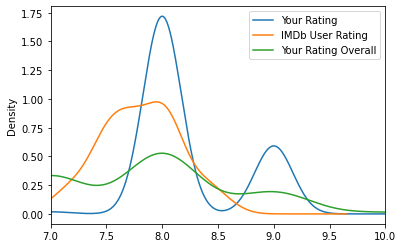

In [331]:
grouped_df.get_group(2)['Your Rating'].plot(kind = 'kde', label = 'Your Rating')
grouped_df.get_group(2)['IMDb Rating'].plot(kind = 'kde', label = 'IMDb User Rating')
data_film_orig['Your Rating'].plot(kind = 'kde', label = 'Your Rating Overall')
plt.xlim(7, 10)
plt.legend()
plt.show()

In [333]:
# Saving Clusters 
data_film_orig.to_csv('Data/Clusters_from_Kmean_mode_prot.csv')

### Modelling to check performance of clusters 
Modelling as a regression task, to predict the rating given to a movie, although using clusters formed using this information is a form of target leak, it can give a indication of which clustering method encoded the most info about the target.<br>
K-Prototypes had the most info about the preference of the user, best for our task of finding clusters of movies the author likes/dislikes.<br>
Posing as a Classification problem by converting the labels into preference (>7) and not-preferred (<=7) gives upwards of .9 F-1 score. So, the clusters definitely have preference encoded in them.

|Method   | Train R<sup>2</sup>| Test R<sup>2</sup>  | 
|---|---|---|
|Vanilla, using num features only|0.786|0.168
|Using Kmeans Clusters|0.848|0.460
|Using Kmodes Clusters |0.811|0.143
|Using Kprototypes Clusters |0.878|0.524
|Using Kmeans Clusters including IMDB ratings|0.909|0.368
|Using Kmeans Clusters with PCA and encoded categorical columns|0.824|0.586



In [ ]:
kmeans - 0.523
kmodes - 0.1436
k prot 0.466
Kmeans Compare - 0.52112
Kmeans PCA Categ - 0.597

In [378]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report

In [434]:
data_film = data_film_backup.copy()
data_film[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7']] = data_film.Genres.str.split(',', expand=True)
data_film.drop(['Genre2','Genre3', 'Genre4','Genre5','Genre6','Genre7'], axis= 1, inplace = True)
# Loss of info by dropping secondary, tertiary genres but will result in duplication, is complex.
# Loss of info, Lee ukreich, ethan and joel coen etc are big loosers. Complex fix later.
data_film[['Director1','Director2','Director3', 'Director4']] = data_film.Directors.str.split(',', expand=True)
data_film.drop(['Director2','Director3', 'Director4'], axis = 1, inplace = True)
data_film.drop(['Genres', 'Directors'], axis = 1, inplace = True)
data_film = pd.get_dummies(data_film, prefix='Genre', columns=['Genre1'])
data_film = pd.get_dummies(data_film, prefix='Director', columns=['Director1'])
data_film[['Rated_Year', 'Rated_month', 'Rated_Day']] = data_film['Date Rated'].str.split('-', expand = True)
data_film.drop(['Rated_month', 'Rated_Day'], axis = 1, inplace = True)
data_film.drop('Date Rated', axis = 1, inplace = True)
data_film[['Release_Year', 'Release_month', 'Release_Day']] = data_film['Release Date'].str.split('-', expand = True)
data_film.drop(['Release_month', 'Release_Day'], axis = 1, inplace = True)
data_film.drop('Release Date', axis = 1, inplace = True)
data_film.drop(['Title Type', 'URL'], axis = 1, inplace = True)
data_film = pd.get_dummies(data_film, prefix='Censor_rating', columns=['Rated'])
#data_film = pd.get_dummies(data_film, prefix='Major_awards', columns=['Major_Awards'])
#data_film = pd.get_dummies(data_film, prefix='Metascore_binned', columns=['Metascore_binned'])
#data_film = pd.get_dummies(data_film, prefix='Box_office_binned', columns=['Box_office_binned'])
data_film = pd.get_dummies(data_film, prefix='Country', columns=['Country'])
data_film = pd.get_dummies(data_film, prefix='Language', columns=['Language'])
data_film.drop(['Metascore_binned'], axis = 1, inplace=True)
data_film.drop(['Box_office_binned'], axis = 1, inplace=True)
data_film.drop(['Title'], axis = 1, inplace=True)
data_film.drop(['Release_Year'], axis = 1, inplace=True)
data_film['Rated_Year'] = data_film['Rated_Year'].astype(int)
#data_film.drop(['IMDb Rating'], axis = 1, inplace=True)

### Adding clusters that have seen the true labels is a type of leakage - won't be available in production, still check

In [435]:
#clustered_data = pd.read_csv('Data/Clusters_from_Kmean_mode_prot_1.csv', index_col=0)
#data_film['Clusters'] = clustered_data.Cluster_K_Prototype
data_film['Clusters'] = data_film_orig.Cluster_Categ_PCA
labels = data_film['Your Rating'].copy()
data_film.drop(['Your Rating', 'IMDb Rating'], axis = 1, inplace=True)

In [436]:
# as classification task
#labels[labels > 7] = 1
#labels[labels != 1] = 0
#labels.value_counts()

In [ ]:
#film_data_pred= (film_data_pred.select_dtypes(np.number))

In [437]:
x_train, x_test, y_train, y_test = train_test_split(data_film, labels, test_size = 0.3, random_state = 10)
xgb = XGBRegressor(n_estimators = 100, objective = 'reg:squarederror',
                     learning_rate=.1, eval_metric = 'rmse')
#xgb = XGBClassifier(n_estimators = 100, objective = 'binary:logistic',
#                     learning_rate=.1, eval_metric = 'auc')

In [438]:
xgb.fit(x_train, y_train, 
       early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],
             verbose=True)

[0]	validation_0-rmse:6.31899
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:5.67810
[2]	validation_0-rmse:5.10014
[3]	validation_0-rmse:4.58164
[4]	validation_0-rmse:4.11437
[5]	validation_0-rmse:3.69348
[6]	validation_0-rmse:3.31651
[7]	validation_0-rmse:2.97827
[8]	validation_0-rmse:2.67515
[9]	validation_0-rmse:2.40265
[10]	validation_0-rmse:2.15955
[11]	validation_0-rmse:1.94236
[12]	validation_0-rmse:1.75010
[13]	validation_0-rmse:1.58203
[14]	validation_0-rmse:1.43476
[15]	validation_0-rmse:1.30169
[16]	validation_0-rmse:1.18892
[17]	validation_0-rmse:1.09480
[18]	validation_0-rmse:1.01419
[19]	validation_0-rmse:0.94508
[20]	validation_0-rmse:0.88102
[21]	validation_0-rmse:0.83096
[22]	validation_0-rmse:0.79012
[23]	validation_0-rmse:0.75717
[24]	validation_0-rmse:0.73229
[25]	validation_0-rmse:0.71334
[26]	validation_0-rmse:0.69957
[27]	validation_0-rmse:0.69079
[28]	validation_0-rmse:0.68415
[29]	validation_0-rmse:0.67906
[30]	validation_

KeyError: 'base_score'

KeyError: 'base_score'

In [439]:
xgb.score(x_train, y_train)

0.781878494112155

In [440]:
preds = xgb.predict(x_test)
r2_score(y_test, preds)

0.5975812263860091

In [446]:
#print(classification_report(y_test, preds))

In [442]:
pd.DataFrame(data = xgb.feature_importances_, index = data_film.columns).sort_values(by = 0, ascending = False)

0
Clusters                            0.550317
Genre_Drama                         0.015098
Major_Awards                        0.012736
Censor_rating_Not Rated             0.012157
Director_James Wan                  0.012044
Director_Lilly Wachowski            0.011867
Director_Steven Spielberg           0.011530
Director_Rajkumar Hirani            0.011226
Language_Multilingual/Foreign       0.010162
Director_Mel Gibson                 0.009759
Country_UK                          0.009352
Genre_Documentary                   0.009130
Num Votes                           0.009100
Director_Zach Braff                 0.009041
Year                                0.008824
Genre_Biography                     0.008768
Director_Jonathan Levine            0.008593
Director_Siddharth Anand            0.008585
Director_Roar Uthaug                0.008585
Director_Peter Sollett              0.008551
Censor_rating_PG-13                 0.008530
Director_Peter Segal                0.008411
Director_Ratnaa Sinha               0.008336
Director_Jim Field Smith            0.008167
Director_Sujoy Ghosh                0.008103
Director_James Cameron              0.007898
Director_Gulzar                     0.007792
Director_R. Balki                   0.007701
Director_Michael Sucsy              0.007668
Rated_Year                          0.007574
Director_Luke Greenfield            0.007563
Director_James Gunn                 0.007372
Director_Siddharth Malhotra         0.007348
Director_Luv Ranjan                 0.007198
Director_Robert Rodriguez           0.007178
Director_Christopher Nolan          0.007140
Director_Robert Zemeckis            0.006983
Director_Evan Goldberg              0.006892
Director_Jennifer Lee               0.006846
Director_Rob Letterman              0.006841
Censor_rating_PG                    0.006759
Country_USA                         0.006756
Genre_Adventure                     0.006565
Director_John G. Avildsen           0.006474
Runtime (mins)                      0.006216
Genre_Crime                         0.005964
Country_South Korea                 0.005725
Director_Peter Weir                 0.005667
Director_Luca Guadagnino            0.005603
Director_Shimit Amin                0.005272
Director_Doug Liman                 0.005264
Director_Ron Howard                 0.005208
Director_J.J. Abrams                0.004592
Director_Ashutosh Gowariker         0.004298
Director_Vikas Bahl                 0.004005
Director_Gurinder Chadha            0.003933
Director_Danny Boyle                0.003557
Director_Bryan Singer               0.003491
Director_Ivan Reitman               0.003036
Director_Jonathan Demme             0.002786
Censor_rating_R                     0.001226
Director_Lasse Hallstr�m            0.000638
Director_Richard Linklater          0.000000
Director_Rick Famuyiwa              0.000000
Director_Ari Aster                  0.000000
Director_Richard Curtis             0.000000
Director_Richard Attenborough       0.000000
Director_Rich Moore                 0.000000
Director_Rian Johnson               0.000000
Director_Ridley Scott               0.000000
Director_Rob Reiner                 0.000000
Director_Adam Shankman              0.000000
Director_Adam McKay                 0.000000
Director_Rob Minkoff                0.000000
Director_Ramesh Sippy               0.000000
Director_Adam Carolla               0.000000
Director_Robert Wise                0.000000
Director_Abhishek Sharma            0.000000
Director_Roberto Benigni            0.000000
Director_Rod Blackhurst             0.000000
Director_Ruben Fleischer            0.000000
Director_Saket Chaudhary            0.000000
Director_Sam Mendes                 0.000000
Director_Sandeep Reddy Vanga        0.000000
Director_Aditya Dhar                0.000000
Director_Quentin Tarantino          0.000000
Director_Ram Madhvani               0.000000
Director_Adrian Molina              0.000000
Director_Mike Nichols               0.